In [80]:
from hidrocomp.series import Flow
import pandas as pd
import plotly.graph_objects as go
import pymc3 as pm
import matplotlib.pyplot as plt

In [81]:
flow_ana = Flow(data=pd.read_csv("ana.csv", index_col=0, parse_dates=True))
flow_sar = Flow(data=pd.read_csv("sar.csv", index_col=0, parse_dates=True))
flow_ons = Flow(data=pd.read_csv("ons.csv", index_col=0, parse_dates=True))

In [82]:
flow = flow_ana.data.combine_first(flow_sar.data).combine_first(flow_ons.data)
flow

,66160000,66231000,A19086,D19086,MANSO
1972-08-07,11.2110,NaN,NaN,NaN,NaN
1972-08-08,11.2110,NaN,NaN,NaN,NaN
1972-08-09,11.6272,NaN,NaN,NaN,NaN
1972-08-10,11.6272,NaN,NaN,NaN,NaN
1972-08-11,11.6272,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-07-18,NaN,NaN,41.94,121.0,NaN
2020-07-19,NaN,NaN,34.02,121.0,NaN
2020-07-20,NaN,NaN,41.93,121.0,NaN
2020-07-21,NaN,NaN,34.02,121.0,NaN


In [83]:
flow['66160000']

1972-08-07    11.2110
1972-08-08    11.2110
1972-08-09    11.6272
1972-08-10    11.6272
1972-08-11    11.6272
               ...   
2020-07-18        NaN
2020-07-19        NaN
2020-07-20        NaN
2020-07-21        NaN
2020-07-22        NaN
Name: 66160000, Length: 17517, dtype: float64

In [84]:
starting_month='AS-AUG'
max_data = flow['66160000'].groupby(pd.Grouper(freq=starting_month)).max()
max_data.dropna()
max_data_impact = max_data['01-01-2001':].dropna()
max_data_impact

2001-08-01    1037.400
2002-08-01     621.957
2003-08-01     873.026
2004-08-01     650.204
2005-08-01     687.791
2006-08-01     534.655
2007-08-01     824.038
2008-08-01     378.102
2010-08-01     799.528
2011-08-01     531.079
2012-08-01     595.900
2013-08-01     745.529
2014-08-01     455.792
2015-08-01     939.381
2016-08-01     284.188
Name: 66160000, dtype: float64

In [85]:
def glm(max_data):
    with pm.Model() as model:
        # specify glm and pass in data. The resulting linear model, its likelihood and
        # and all its parameters are automatically added to our model.
        sigma = pm.HalfCauchy('sigma', beta=10)
        intercept = pm.Normal('Intercept', 0, sigma=20)
        x_coeff = pm.Normal('x', 0, sigma=10)

        likelihood = pm.Normal('y', mu=intercept + x_coeff * max_data.index.year, sigma=sigma, observed=max_data)

        trace = pm.sample(2000, cores=1, chains=1) # draw 3000 posterior samples using NUTS sampling
    return trace

trace = glm(max_data_impact)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|███████████████████████████████████████████| 2500/2500 [00:01<00:00, 1425.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016F7FDDDB88>,
      dtype=object)

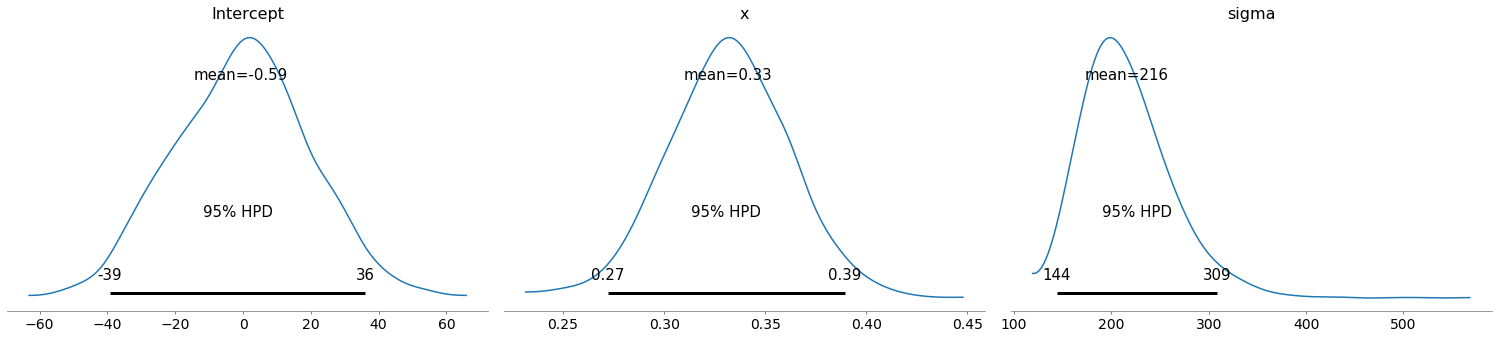

In [86]:
pm.plots.plot_posterior(trace, credible_interval=0.95)

In [87]:
posterior=pm.trace_to_dataframe(trace)
summary=pm.summary(trace)
summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.594,19.901,-36.575,35.706,0.486,0.398,1675.0,1249.0,1676.0,1561.0,NaN
x,0.331,0.030,0.274,0.386,0.001,0.001,1517.0,1491.0,1518.0,1412.0,NaN
sigma,216.235,46.375,143.299,299.189,1.245,0.925,1387.0,1258.0,1559.0,1224.0,NaN


In [88]:
intercept = [summary['mean'].loc['Intercept'], summary['hpd_97%'].loc['Intercept'], summary['hpd_3%'].loc['Intercept']]
slope = [summary['mean'].loc['x'], summary['hpd_97%'].loc['x'], summary['hpd_3%'].loc['x']]
years = pd.Series(max_data.index.year)
fig = go.Figure()
regression = years.map(lambda x: x*slope[0]+intercept[0])
fig.add_trace(go.Scatter(x=max_data.index.year, y=max_data.values, mode='markers', name='66160000'))
fig.add_trace(go.Scatter(x=max_data.index.year, y=regression.values, mode='lines', name='Regression', line=dict(width=2)))

#Plot possible regressions
regression_temp = years.map(lambda x: x*posterior['x'].iloc[0]+posterior['Intercept'].iloc[0])
fig.add_trace(go.Scatter(x=max_data.index.year, y=regression_temp.values, mode='lines', name='Possible regressions', line=dict(color='grey', width=.05)))
for i in range(1,300):
    regression_temp = years.map(lambda x: x*posterior['x'].iloc[i]+posterior['Intercept'].iloc[i])
    fig.add_trace(go.Scatter(x=max_data.index.year, y=regression_temp.values, mode='lines', name='Possible regressions', showlegend=False, line=dict(color='grey', width=.05)))
fig.update_layout(title="Linear regression for 66160000 (Impact)", xaxis_title="Time (years)", yaxis_title="Annual max discharge (m³/s)")
fig.show()

In [89]:
trace = glm(max_data)

C:\Users\User\anaconda3\lib\site-packages\pymc3\model.py:1430: ImputationWarning:

Data in y contains missing values and will be automatically imputed from the sampling distribution.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [y_missing, x, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:03<00:00, 633.88it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.009,20.064,-37.093,38.337,0.478,0.434,1760.0,1067.0,1769.0,1424.0,NaN
x,0.372,0.019,0.335,0.407,0.000,0.000,1987.0,1963.0,1992.0,1370.0,NaN
y_missing[0],748.171,206.615,350.373,1121.190,4.026,2.919,2634.0,2505.0,2633.0,1601.0,NaN
y_missing[1],748.648,218.427,367.440,1185.576,4.384,3.166,2482.0,2381.0,2471.0,1487.0,NaN
y_missing[2],751.459,217.206,343.874,1151.289,4.988,3.915,1896.0,1540.0,1917.0,1284.0,NaN
y_missing[3],749.384,218.526,349.332,1160.754,4.778,3.394,2092.0,2073.0,2140.0,1229.0,NaN
sigma,212.164,23.299,169.084,256.326,0.533,0.382,1909.0,1861.0,1957.0,1435.0,NaN


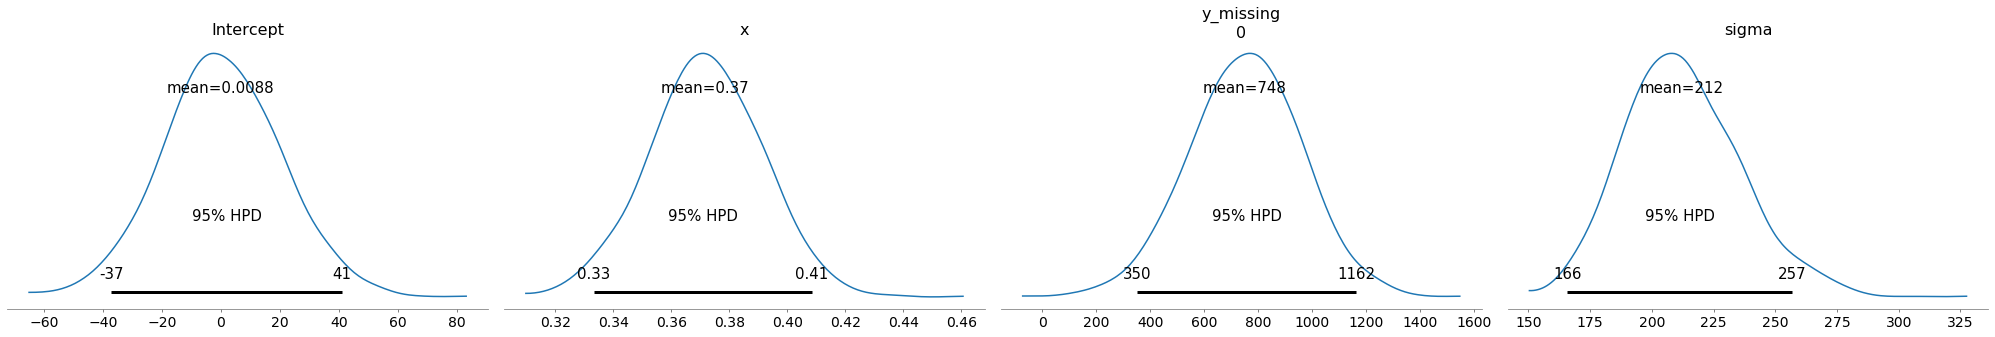

In [90]:
pm.plots.plot_posterior(trace, credible_interval=0.95)
posterior=pm.trace_to_dataframe(trace)
summary=pm.summary(trace)
summary

In [91]:
intercept = [summary['mean'].loc['Intercept'], summary['hpd_97%'].loc['Intercept'], summary['hpd_3%'].loc['Intercept']]
slope = [summary['mean'].loc['x'], summary['hpd_97%'].loc['x'], summary['hpd_3%'].loc['x']]
years = pd.Series(max_data.index.year)
fig = go.Figure()
regression = years.map(lambda x: x*slope[0]+intercept[0])
fig.add_trace(go.Scatter(x=max_data.index.year, y=max_data.values, mode='markers', name='66160000'))
fig.add_trace(go.Scatter(x=max_data.index.year, y=regression.values, mode='lines', name='Regression', line=dict(width=2)))

#Plot possible regressions
regression_temp = years.map(lambda x: x*posterior['x'].iloc[0]+posterior['Intercept'].iloc[0])
fig.add_trace(go.Scatter(x=max_data.index.year, y=regression_temp.values, mode='lines', name='Possible regressions', line=dict(color='grey', width=.05)))
for i in range(1,300):
    regression_temp = years.map(lambda x: x*posterior['x'].iloc[i]+posterior['Intercept'].iloc[i])
    fig.add_trace(go.Scatter(x=max_data.index.year, y=regression_temp.values, mode='lines', name='Possible regressions', showlegend=False, line=dict(color='grey', width=.05)))
fig.update_layout(title="Linear regression for 66160000", xaxis_title="Time (years)", yaxis_title="Annual max discharge (m³/s)")
fig.show()

In [92]:
flow['MANSO']

1972-08-07   NaN
1972-08-08   NaN
1972-08-09   NaN
1972-08-10   NaN
1972-08-11   NaN
              ..
2020-07-18   NaN
2020-07-19   NaN
2020-07-20   NaN
2020-07-21   NaN
2020-07-22   NaN
Name: MANSO, Length: 17517, dtype: float64

In [93]:
starting_month='AS-AUG'
max_data = flow['MANSO'].groupby(pd.Grouper(freq=starting_month)).max()
max_data_impact = max_data['01-01-2001':].dropna()
max_data = max_data.dropna()

In [94]:
trace = glm(max_data_impact)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|███████████████████████████████████████████| 2500/2500 [00:02<00:00, 1167.14it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.382,20.619,-38.151,38.726,0.517,0.474,1588.0,946.0,1587.0,1260.0,NaN
x,0.628,0.056,0.533,0.736,0.001,0.001,1579.0,1579.0,1635.0,1196.0,NaN
sigma,446.229,85.073,310.035,606.634,2.160,1.638,1551.0,1350.0,1753.0,1319.0,NaN


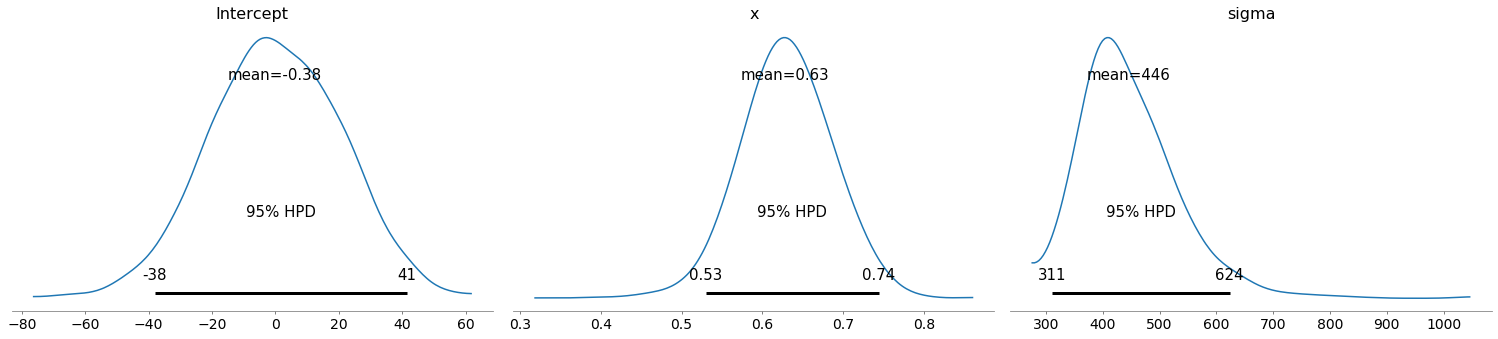

In [95]:
pm.plots.plot_posterior(trace, credible_interval=0.95)
posterior=pm.trace_to_dataframe(trace)
summary=pm.summary(trace)
summary

In [96]:
intercept = [summary['mean'].loc['Intercept'], summary['hpd_97%'].loc['Intercept'], summary['hpd_3%'].loc['Intercept']]
slope = [summary['mean'].loc['x'], summary['hpd_97%'].loc['x'], summary['hpd_3%'].loc['x']]
years = pd.Series(max_data_impact.index.year)
fig = go.Figure()
regression = years.map(lambda x: x*slope[0]+intercept[0])
fig.add_trace(go.Scatter(x=max_data_impact.index.year, y=max_data_impact.values, mode='markers', name='Manso Natural'))
fig.add_trace(go.Scatter(x=max_data_impact.index.year, y=regression.values, mode='lines', name='Regression', line=dict(width=2)))

#Plot possible regressions
regression_temp = years.map(lambda x: x*posterior['x'].iloc[0]+posterior['Intercept'].iloc[0])
fig.add_trace(go.Scatter(x=max_data_impact.index.year, y=regression_temp.values, mode='lines', name='Possible regressions', line=dict(color='grey', width=.05)))
for i in range(1,300):
    regression_temp = years.map(lambda x: x*posterior['x'].iloc[i]+posterior['Intercept'].iloc[i])
    fig.add_trace(go.Scatter(x=max_data_impact.index.year, y=regression_temp.values, mode='lines', name='Possible regressions', showlegend=False, line=dict(color='grey', width=.05)))
fig.update_layout(title="Linear regression for Manso (Impact)", xaxis_title="Time (years)", yaxis_title="Annual max discharge (m³/s)")
fig.show()

In [97]:
trace = glm(max_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x, Intercept, sigma]
Sampling chain 0, 0 divergences: 100%|███████████████████████████████████████████| 2500/2500 [00:02<00:00, 1141.50it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.322,19.753,-37.215,36.185,0.449,0.406,1933.0,1184.0,1948.0,1476.0,NaN
x,0.581,0.032,0.519,0.639,0.001,0.001,1708.0,1691.0,1720.0,1318.0,NaN
sigma,372.190,46.300,289.681,453.800,1.000,0.722,2145.0,2059.0,2208.0,1350.0,NaN


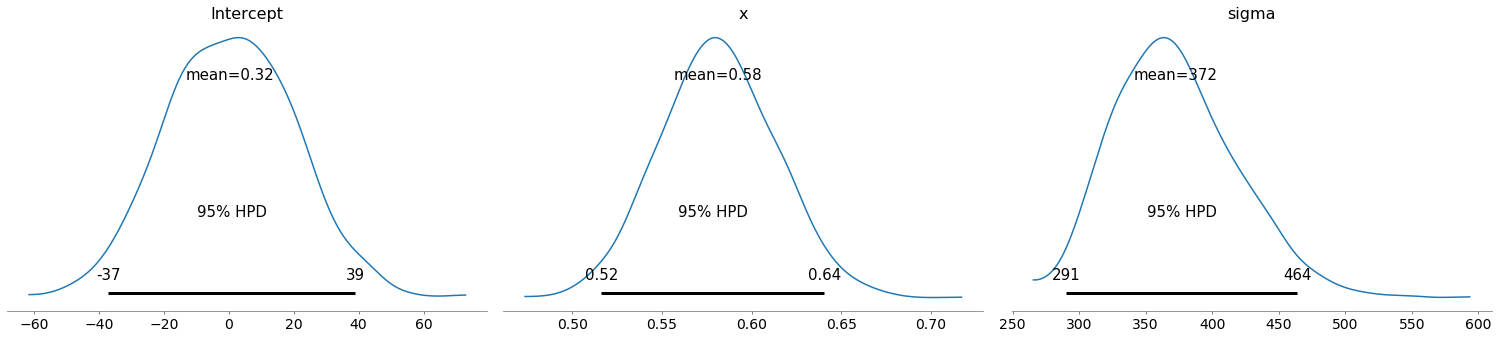

In [98]:
pm.plots.plot_posterior(trace, credible_interval=0.95)
posterior=pm.trace_to_dataframe(trace)
summary=pm.summary(trace)
summary

In [100]:
intercept = [summary['mean'].loc['Intercept'], summary['hpd_97%'].loc['Intercept'], summary['hpd_3%'].loc['Intercept']]
slope = [summary['mean'].loc['x'], summary['hpd_97%'].loc['x'], summary['hpd_3%'].loc['x']]
years = pd.Series(max_data.index.year)
fig = go.Figure()
regression = years.map(lambda x: x*slope[0]+intercept[0])
fig.add_trace(go.Scatter(x=max_data.index.year, y=max_data.values, mode='markers', name='66160000'))
fig.add_trace(go.Scatter(x=max_data.index.year, y=regression.values, mode='lines', name='Regression', line=dict(width=2)))

#Plot possible regressions
regression_temp = years.map(lambda x: x*posterior['x'].iloc[0]+posterior['Intercept'].iloc[0])
fig.add_trace(go.Scatter(x=max_data.index.year, y=regression_temp.values, mode='lines', name='Possible regressions', line=dict(color='grey', width=.05)))
for i in range(1,300):
    regression_temp = years.map(lambda x: x*posterior['x'].iloc[i]+posterior['Intercept'].iloc[i])
    fig.add_trace(go.Scatter(x=max_data.index.year, y=regression_temp.values, mode='lines', name='Possible regressions', showlegend=False, line=dict(color='grey', width=.05)))
fig.update_layout(title="Linear regression for Manso", xaxis_title="Time (years)", yaxis_title="Annual max discharge (m³/s)")
fig.show()